### Парсер статистики прослушиваний LastFM

Данный парсер осуществляет сбор с сервиса LastFM статистики прослушиваний по выбранному исполнителю и указывает 50 первых композиций с частотой прослушиваний за весь период предоставления сервиса, а также (опционально) выводится частота прослушиваний первых 5 композиций в виде круговой диаграммы. 

Также, опционально может выводиться список исполнителей, которых рекомендательная система LastFM считает похожими на текущего исполнителя.

В случае если не все ссылки доступны (перемещение файла на youtube и повреждение ссылки) и данные искажены (нет возможности прослушивания из-за битых ссылок), выдаётся список доступных для прослушивания из первых пятидесяти записей (без разбивки на столбцы и диаграммы).

In [1]:
# !pip install requests
# !pip install beautifulSoup4
from pprint import pprint # Импортируем функцию pprint()
import json # Импортируем модуль json
import requests
import pandas as pd
import numpy as np
from bs4  import BeautifulSoup
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def scrobbling_stats(name, save=False, plot=True, simshow=True, filename='scr_data.csv'):
  print()
  urllink='https://www.last.fm/ru/music/{}/+tracks?date_preset=ALL#top-tracks'.format(name)
  response = requests.get(urllink,  headers={'User-Agent': 'Mozilla/5.0'})
  page = BeautifulSoup(response.text, 'html.parser')
  tagdict=dict()
  for s in list([tag.name for tag in page.find_all()]):
      z=" ".join(page.find(s).text.split())
      if len(z)>0 and s!=("style" and "script"): #Удаление пустых тегов и сецификации стиля
        tagdict[s]=z
  a=pd.Series(tagdict['table'].split('Воспроизвести')).str.replace("Отметить композицию как любимую ", "").iloc[1:]
  a=a.str.replace("Купить Загрузка Больше Эта композиция - мое увлечение Получить композицию Загрузка", "") 
  try: # Работа при работающих ссылках
    compo, listeners=[*a.str.split("  ", expand=True).T.values]
  except: # Работа при наличии повреждённых ссылок
    return a.reset_index().iloc[:,1].str.split("слушат*", expand=True).iloc[:, :1]
  listtable=pd.DataFrame(listeners, index=list(compo)).iloc[1:, 0].str.split("слушат*", expand=True).iloc[:, :1]
  listtable.columns=['Artist']
  listtable=listtable.Artist.str.replace(" ", "").astype('uint32')
  similars=list(set([word.get_text().strip('\n') for word in page.find_all('h3')]) \
  .difference(set(['Перспективные композиции', 'Похожие исполнители', 'Скробблишь из Spotify?'])))
  if save:
    print(listtable, file=open(filename,'w'))
  if plot:
    plt.pie(listtable[:5], autopct='%.0f%%')
    plt.title('Top 5 compositions ratio')
    plt.show()
  if simshow:
    print('List of similar artists:', '\n')
    print(*similars, sep='\n')
    print('\n' )  
  return listtable

Input name of the artist: Jam


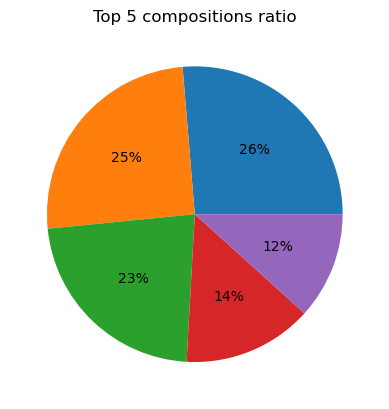

List of similar artists: 

Madness
The Stranglers
Stiff Little Fingers
The Style Council
Squeeze
The Clash
Buzzcocks
Small Faces
The Beat
Dexys Midnight Runners
The Undertones
Paul Weller




 Going Underground                             283482
 That's Entertainment                          271973
 In the City                                   242836
 Start!                                        152863
 The Eton Rifles                               125976
 English Rose                                  124648
 David Watts                                    96897
 Beat Surrender                                 80112
 Down in the Tube Station at Midnight           72319
 The Modern World                               72177
 All Mod Cons                                   69180
 Art School                                     61867
 Pretty Green                                   61006
 Absolute Beginners                             60816
 News of the World                              59942
 Ghosts                                         59676
 Strange Town                                   59424
 All Around the World                           57468
 When You're Young          

In [5]:
scrobbling_stats(name=input('Input name of the artist:'),
                 save=True, 
                 plot=True, 
                 simshow=True, 
                 filename='TL_scrobbling stat.csv')